# How to create analytical signals for simulation and optimization
**Use predefined signals from Boulder Opal**

Boulder Opal contains analytical signals in the form of [piecewise-constant functions](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/Pwc) (Pwcs), which can be used for simulation and optimization.
The full list of Pwc analytical signals is available in the [reference documentation](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/nodes#signals).

All signals require a `duration`, defining the time interval for the signal between zero and `duration`. 
The signals also require a `segment_count`, which determines the number of segments in the Pwc.
Many of the signal parameters can be passed as tensors and thus can be optimized to minimize a given cost function.

In this notebook we show how to create signals for use in simulation and optimization.
You can also define your own analytical Hamiltonians from the ground up, see [this user guide](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-define-continuous-analytical-hamiltonians) for more information.

## Summary workflow

### 1. Create a node defining the signal
Once a graph has been set up for the system, create a Pwc analytic signal using one of the signals from the [signal library](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/nodes#signals).
If one is running an optimization problem, define the optimizable signal parameters using `graph.optimization_variable` or `graph.optimizable_scalar`, before defining the signal.
Then add the signal (multiplied by the appropriate operator) to the Hamiltonian.

### 2. Execute the graph for the simulation/optimization
With the graph object created, a simulation can be run using the `boulderopal.execute_graph` function. The outputs and the graph must be provided. The function returns the results of the simulation. 

Alternatively, an optimization can be run using the `boulderopal.run_optimization` function or the `boulderopal.run_stochastic_optimization` function. The cost, the outputs, and the graph must be provided. The function returns the results of the optimization. 

## Example: Simulation with analytical signals 

In this example, we will simulate two interacting qubits (labeled 0 and 1), with one of the qubits (qubit 0) driven by an external signal. 

The Hamiltonian for the system is 
$$
H(t) = \frac{1}{2} \left(\Omega(t) \sigma^{-}_{0} + \Omega(t)^* \sigma^{+}_{0} \right) + \sum_{i=x,y,z} \delta_i \sigma^{i}_{0} \sigma^{i}_{1} ,
$$
where $\Omega(t)$ is the external signal and $\delta_i$ is the qubit coupling.

The signal used for this example is the Gaussian signal, `graph.signals.gaussian_pulse_pwc`, defined as
$$\Omega(t) =
           \begin{cases}
                A
                \exp \left(- \frac{(t-t_1)^2}{2\sigma^2} \right)
                    &\mathrm{if} \quad t < t_1=t_0- t_\mathrm{flat}/2 \\
                A
                    &\mathrm{if} \quad t_0-t_\mathrm{flat}/2 \le t < t_0+t_\mathrm{flat}/2 \\
                A
                \exp \left(- \frac{(t-t_2)^2}{2\sigma^2} \right)
                    &\mathrm{if} \quad t > t_2=t_0+t_\mathrm{flat}/2
            \end{cases}  ,
$$
where $A$ is the amplitude, 
$\sigma$ is the width of the Gaussian, 
$t_0$ is the center of the signal, and
$t_\mathrm{flat}$ is the flat duration. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qctrlvisualizer as qv
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

In [2]:
# Create the data flow graph describing the system.
graph = bo.Graph()

# Define the duration of the pulse.
duration = 4e-6  # s

# Define the parameters of the pulse.
# Use a minimal segmentation for a more efficient sampling.
pulse = graph.signals.gaussian_pulse_pwc(
    duration=duration,
    segment_count=100,
    amplitude=2 * np.pi * 1.0e6,  # rad/s
    width=duration * 0.1,
    flat_duration=duration * 0.2,
    segmentation="MINIMAL",
    name="$\\Omega$",
)

# Add the pulse terms to the Hamiltonian.
hamiltonian = graph.hermitian_part(
    pulse * graph.pauli_kronecker_product([("M", 0)], subsystem_count=2)
)

# Add the qubit-qubit coupling terms to the Hamiltonian.
couplings = {"X": 8.0e6, "Y": 8.0e6, "Z": 9.0e6}  # rad/s

for i, coupling in couplings.items():
    hamiltonian += coupling * graph.pauli_kronecker_product(
        [(i, 0), (i, 1)], subsystem_count=2
    )

In [3]:
sample_times = np.linspace(0.0, duration, 100)

# Compute the unitary using `time_evolution_operators_pwc`.
unitaries = graph.time_evolution_operators_pwc(
    hamiltonian=hamiltonian, sample_times=sample_times
)

# Define the initial state.
initial_state = graph.fock_state(4, 0)[:, None]

# Evolve the initial state with the unitary to get the final state.
evolved_states = unitaries @ initial_state
evolved_states.name = "states"

# Run simulation.
result = bo.execute_graph(graph=graph, output_node_names=["$\\Omega$", "states"])

Your task (action_id="1829414") has completed.


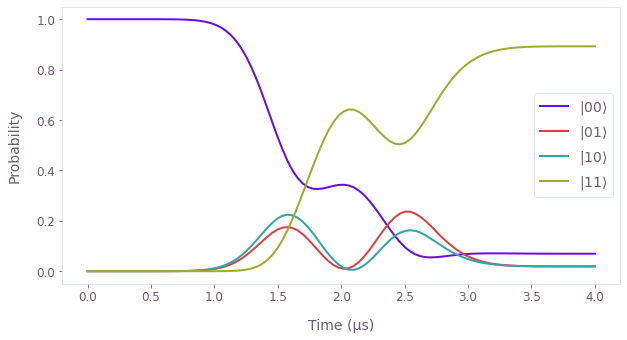

In [4]:
# Plot the evolution of the populations of the qubits using `plot_population_dynamics`.
states = result["output"].pop("states")
qubit_populations = np.abs(states["value"].squeeze()) ** 2

qv.plot_population_dynamics(
    sample_times, {rf"$|{k:02b}\rangle$": qubit_populations[:, k] for k in range(4)}
)

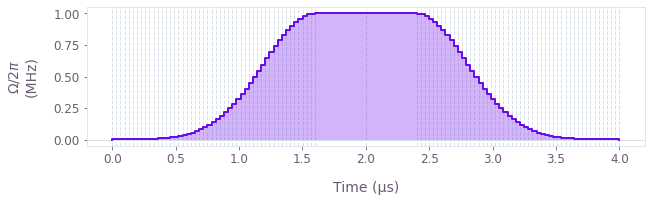

In [5]:
# View the generated Gaussian pulse using the `plot_controls` function.
qv.plot_controls(result["output"])

## Example: Optimization with analytical signals 

In this example, we will implement an X gate in a noisy single-qubit system, by optimizing the parameters of two signals. 

The Hamiltonian for the system is 
$$
H(t) = \alpha(t) \sigma_{z} + \frac{1}{2}\left(\gamma(t)\sigma_{-} + \gamma^*(t)\sigma_{+}\right) + \delta \sigma_{z} + \zeta(t) \sigma_{z} , 
$$
where $\alpha(t)$ and $\gamma(t)$ are signals with optimizable parameters, $\delta$ is the qubit detuning, and $\zeta(t)$ is a dephasing noise process.

The $\alpha(t)$ signal acting on $\sigma_{z}$ is a hyperbolic tangent ramp, `graph.signals.tanh_ramp_pwc`, defined by
$$
\alpha(t) = \frac{a_+ + a_-}{2}
                + \frac{a_+ - a_-}{2} \tanh\left( \frac{t - t_0}{t_\mathrm{ramp}} \right)  ,
$$
where $a_\pm$ are the asymptotic values of the signal, $t_0$ is the center time, and $t_\mathrm{ramp}$ is the characteristic duration of the ramp.

The $\gamma(t)$ signal acting on $\sigma_{-}$ is a cosine pulse, `graph.signals.cosine_pulse_pwc`, defined by
$$
\gamma(t) = 
\frac{A}{2} \left[1 + \cos \left(\frac{2\pi}{\tau} t- \pi \right)\right] = A \sin^2 \left(\frac{\pi}{\tau}t\right) ,
$$
where $A$ is the amplitude and $\tau$ is the given duration of the signal.

In [6]:
graph = bo.Graph()

# Define the duration of the signals.
duration = 3e-6  # s

# Define the number of segments for Pwc signals.
segment_count = 100

# Define α tanh ramp acting on sigma_z.
alpha_start_value = graph.optimizable_scalar(
    lower_bound=-3e7, upper_bound=3e7, name="alpha_start_value"
)
alpha_end_value = graph.optimizable_scalar(
    lower_bound=-3e7, upper_bound=3e7, name="alpha_end_value"
)
alpha_ramp_duration = graph.optimizable_scalar(
    lower_bound=0.1e-6, upper_bound=duration, name="alpha_ramp_duration"
)
alpha_center_time = graph.optimizable_scalar(
    lower_bound=0.0, upper_bound=duration, name="alpha_center_time"
)
alpha_ramp = graph.signals.tanh_ramp_pwc(
    duration=duration,
    segment_count=segment_count,
    start_value=alpha_start_value,
    end_value=alpha_end_value,
    ramp_duration=alpha_ramp_duration,
    center_time=alpha_center_time,
    name=r"$\alpha$",
)

# Define γ cosine pulse acting on sigma_-.
gamma_amplitude = graph.optimizable_scalar(
    lower_bound=-2.0 * np.pi * 1e6,  # rad/s
    upper_bound=2.0 * np.pi * 1e6,  # rad/s
    name="gamma_amplitude",
)
gamma_pulse = graph.signals.cosine_pulse_pwc(
    duration=duration,
    segment_count=segment_count,
    amplitude=gamma_amplitude,
    flat_duration=duration * 0.2,
    name=r"$\gamma$",
)

# Create pulse Hamiltonian.
hamiltonian = alpha_ramp * graph.pauli_matrix("Z")
hamiltonian += graph.hermitian_part(gamma_pulse * graph.pauli_matrix("M"))

# Add detuning term.
delta = 2 * np.pi * 0.25e6  # rad/s
hamiltonian += delta * graph.pauli_matrix("Z")

# Define target gate.
target = graph.target(operator=graph.pauli_matrix("X"))

# Add dephasing noise term.
zeta = 2 * np.pi * 20e3  # rad/s
dephasing = zeta * graph.pauli_matrix("Z")

# Robust infidelity.
robust_infidelity = graph.infidelity_pwc(
    hamiltonian=hamiltonian,
    noise_operators=[dephasing],
    target=target,
    name="robust_infidelity",
)

# Compute the unitary using `time_evolution_operators_pwc`.
unitary = graph.time_evolution_operators_pwc(
    hamiltonian=hamiltonian, sample_times=np.array([duration]), name="unitary"
)

result = bo.run_optimization(
    graph=graph,
    cost_node_name="robust_infidelity",
    output_node_names=[
        "alpha_start_value",
        "alpha_end_value",
        "alpha_ramp_duration",
        "alpha_center_time",
        "gamma_amplitude",
        "unitary",
        r"$\alpha$",
        r"$\gamma$",
    ],
    optimization_count=8,
    seed=1,
)

print(f"Optimized cost: {result['cost']:.3e}")

Your task (action_id="1829415") has started.
Your task (action_id="1829415") has completed.
Optimized cost: 1.711e-09


In [7]:
# Check that the unitary operator associated with the evolution of the system Hamiltonian
# does indeed correspond to an X gate.
result["output"].pop("unitary")["value"].round(5)

array([[[ 1.e-05+4.e-05j, -0.e+00-1.e+00j],
        [ 0.e+00-1.e+00j,  1.e-05-4.e-05j]]])

In [8]:
# Print out the converged signal parameters.
print("Alpha signal")
for param in ["start_value", "end_value"]:
    print(f"\t{param}: \t{result['output'].pop(f'alpha_{param}')['value']:.3e} rad/s")

for param in ["ramp_duration", "center_time"]:
    print(f"\t{param}: \t{result['output'].pop(f'alpha_{param}')['value']:.3e} s")

print("Gamma signal")
for param in ["amplitude"]:
    print(f"\t{param}: \t{result['output'].pop(f'gamma_{param}')['value']:.3e} rad/s")

Alpha signal
	start_value: 	2.726e+06 rad/s
	end_value: 	-5.867e+06 rad/s
	ramp_duration: 	1.451e-06 s
	center_time: 	1.500e-06 s
Gamma signal
	amplitude: 	4.031e+06 rad/s


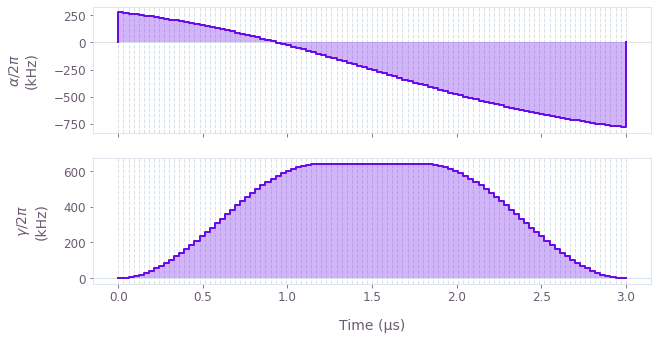

In [9]:
# View the optimized signals using the `plot_controls` function.
qv.plot_controls(result["output"])